# How to use the functions in `validation/photo_z.py`

First make sure the `validation` directory is in your `PYTHONPATH`, then you will be able to import the code.

In [3]:
import photo_z as pz
import matplotlib.pyplot as plt

%matplotlib inline

# Reading in the files

The files can be in one of many formats (so far only text is implemented).

## File formats

Each file *must* contain a column named "objid" that is a unique identifier for that object, and the "objid" for the same object must have exactly the same value across all files that object is in.

* Text files must have their first row be the list of the column names, and must **not** start with any header marking character (e.g. #)
* CSV (same as text)
* FITS Binary Table
* HDF5

The files are read into a `pandas` dataframe. Use these resources if you want to learn more about `pandas`
* [10 minutes to pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html)
* [Video tutorial](https://www.youtube.com/watch?v=w26x-z-BdWQ) by Wes McKinney
* [Walkthrough exercises](https://github.com/estimate/pandas-exercises) from the pandas tutorial by Wes McKinney

The "objid" column becomes the index of the dataframe.

In [4]:
# text file containing photo-z estimates
filename = 'estimates_file.dat'
photoz_df = pz.read_photoz_point_estimates(filename) # '\t' (tab) is default separator

photoz_df.head()

,z_photo,z_quality,i_LSST_obs
objid,,,
1,1.250630,0.073285,25.8016
2,0.990521,0.000220,23.7647
3,0.931483,0.000252,23.6548
4,0.941545,0.000052,24.4626
5,1.142220,0.000580,26.2322


In [5]:
photoz_df.describe()

,z_photo,z_quality,i_LSST_obs
count,99999.000000,9.999900e+04,99999.000000
mean,0.887179,5.385650e-02,25.298091
std,0.523173,4.015462e-01,1.536625
min,-0.017399,1.228160e-07,15.173300
25%,0.511893,3.289440e-05,24.556400
50%,0.763211,1.652570e-04,25.720000
75%,1.133835,1.314765e-03,26.441700
max,4.014350,4.545510e+01,28.408900


In [6]:
# text file containing truth data
filename = 'truth_file.dat'
truth_df = pz.read_photoz_point_estimates(filename, sep='\+s') # '\+s' = whitespace separator

# can see that an objid in this file has same i_LSST_obs as 
# object with same objid in the estimates file
truth_df.head()

,line,id,ra,dec,z_true,stellarmass,u,uerr,g,gerr,r,rerr,i_LSST_obs,ierr,z,zerr,y,yerr,iabs
objid,,,,,,,,,,,,,,,,,,,
1,683100,5982552,61.444099,-54.444000,1.230650,1.436290e+09,99.00000,28.200000,26.66399,0.115078,26.21227,0.073145,25.80165,0.076794,25.18331,0.029214,24.64665,0.117265,-18.854601
2,583924,8409802,60.456402,-54.142601,0.980854,3.965020e+10,27.27051,0.430268,25.99578,0.068033,24.74034,0.020992,23.76468,0.014450,22.92452,0.004626,22.50146,0.015845,-20.916201
3,552535,8081333,61.238201,-54.756802,0.951649,2.899100e+10,26.87371,0.553030,26.27635,0.086675,24.76693,0.021239,23.65483,0.013525,22.85538,0.004446,22.52193,0.015619,-20.692499
4,543640,7702875,61.818401,-55.247398,0.940988,2.190990e+10,27.37654,2.135833,27.57899,0.267135,25.63475,0.044511,24.46260,0.026123,23.62497,0.007827,23.21025,0.030291,-20.029900
5,651316,12555048,61.821499,-55.120399,1.141390,8.130390e+08,26.90030,0.662244,26.82933,0.156523,26.57075,0.111317,26.23222,0.123171,25.69001,0.048046,25.17419,0.213629,-18.122400


# Analysis

## Global statistics

Print and return the standard deviation (`sigma`), median (`bias`), interquartile range (`iqr`) and interquartile range divided by 1.39 (`iqr_sigma`, same as standard deviation for normal distribution) for the quantity:

$ e_z = \frac{(z_p - z)}{(1+z)} $

Not that $z$ in the above could be the "true" redshift or the "spectroscopic" redshift. It depends upon the data supplied in the second argument to `global_stats`

In [7]:
# no selections done on the data
print "Raw global stats:"
sigma, bias, iqr, iqr_sigma = pz.global_stats(photoz_df["z_photo"],  truth_df["z_true"])

Raw global stats:
global sigma: 0.063 global bias: 0.000
global IQR: 0.009 global IQR-sigma: 0.007
total number = 99999 



## Selections

In addition supply a selection to the sample. First create a boolean Series as demonstrated below, then supply this to `global_stats` as the third argument.

Notice when selections are applied the number selected is also printed and returned.

In [8]:
# select only Gold sample (i<25.3) galaxies
print "Gold global stats:"
iGold = (photoz_df["i_LSST_obs"]<=25.3) & (photoz_df["i_LSST_obs"]>0)
sigma, bias, iqr, iqr_sigma, nselect = pz.global_stats(photoz_df["z_photo"],  
                                                       truth_df["z_true"], iGold)

# select only Gold sample (i<25.3) and high photo-z quality (quality<0.13) galaxies
print "Gold and quality cut global stats:"
iGoldQuality = (photoz_df["i_LSST_obs"]<=25.3) & (photoz_df["i_LSST_obs"]>0) & \
               (photoz_df["z_quality"]<0.13) 
sigma, bias, iqr, iqr_sigma, nselect = pz.global_stats(photoz_df["z_photo"],  
                                                       truth_df["z_true"], iGoldQuality)

Gold global stats:
global sigma: 0.034 global bias: 0.000
global IQR: 0.007 global IQR-sigma: 0.005
number selected = 39030 

Gold and quality cut global stats:
global sigma: 0.022 global bias: 0.000
global IQR: 0.006 global IQR-sigma: 0.005
number selected = 38535 



# Joining the tables

Perform joins between the photo-z estimates data and the truth data. The join is done on the "objid" index value. The `join_type` can be specified, with meaning the same as joins in SQL (see [here](http://www.dofactory.com/sql/join) for an explanation of joins).

In [9]:
# left argument (here 1st arg) == left table
# right argument (here 2nd arg) == right table
joined = pz.join_dataframes(photoz_df, truth_df, join_type="left")

# notice both i_LSST_obs columns have been kept, 
# the one from the estimates has suffix "_pz"
# the one from the truth has suffic "_tr"
joined.head()

,z_photo,z_quality,i_LSST_obs_pz,line,id,ra,dec,z_true,stellarmass,u,...,gerr,r,rerr,i_LSST_obs_tr,ierr,z,zerr,y,yerr,iabs
objid,,,,,,,,,,,,,,,,,,,,,
1,1.250630,0.073285,25.8016,683100,5982552,61.444099,-54.444000,1.230650,1.436290e+09,99.00000,...,0.115078,26.21227,0.073145,25.80165,0.076794,25.18331,0.029214,24.64665,0.117265,-18.854601
2,0.990521,0.000220,23.7647,583924,8409802,60.456402,-54.142601,0.980854,3.965020e+10,27.27051,...,0.068033,24.74034,0.020992,23.76468,0.014450,22.92452,0.004626,22.50146,0.015845,-20.916201
3,0.931483,0.000252,23.6548,552535,8081333,61.238201,-54.756802,0.951649,2.899100e+10,26.87371,...,0.086675,24.76693,0.021239,23.65483,0.013525,22.85538,0.004446,22.52193,0.015619,-20.692499
4,0.941545,0.000052,24.4626,543640,7702875,61.818401,-55.247398,0.940988,2.190990e+10,27.37654,...,0.267135,25.63475,0.044511,24.46260,0.026123,23.62497,0.007827,23.21025,0.030291,-20.029900
5,1.142220,0.000580,26.2322,651316,12555048,61.821499,-55.120399,1.141390,8.130390e+08,26.90030,...,0.156523,26.57075,0.111317,26.23222,0.123171,25.69001,0.048046,25.17419,0.213629,-18.122400


# Add a column

Photo-z validation requires the quantity:

$ e_z = \frac{(z_p - z)}{(1+z)} $

to be used in many different ways. Let's pre-calculate it and add it to the dataframe

In [10]:
# add to estimates dataframe
pz.add_ez_column(photoz_df, truth_df["z_true"], photo_z="z_photo", col_name="ez")
photoz_df.head()

,z_photo,z_quality,i_LSST_obs,ez
objid,,,,
1,1.250630,0.073285,25.8016,0.008957
2,0.990521,0.000220,23.7647,0.004880
3,0.931483,0.000252,23.6548,-0.010333
4,0.941545,0.000052,24.4626,0.000287
5,1.142220,0.000580,26.2322,0.000388


In [11]:
# add to joined dataframe
pz.add_ez_column(joined, true_z="z_true", photo_z="z_photo", col_name="ez")
joined.head()

,z_photo,z_quality,i_LSST_obs_pz,line,id,ra,dec,z_true,stellarmass,u,...,r,rerr,i_LSST_obs_tr,ierr,z,zerr,y,yerr,iabs,ez
objid,,,,,,,,,,,,,,,,,,,,,
1,1.250630,0.073285,25.8016,683100,5982552,61.444099,-54.444000,1.230650,1.436290e+09,99.00000,...,26.21227,0.073145,25.80165,0.076794,25.18331,0.029214,24.64665,0.117265,-18.854601,0.008957
2,0.990521,0.000220,23.7647,583924,8409802,60.456402,-54.142601,0.980854,3.965020e+10,27.27051,...,24.74034,0.020992,23.76468,0.014450,22.92452,0.004626,22.50146,0.015845,-20.916201,0.004880
3,0.931483,0.000252,23.6548,552535,8081333,61.238201,-54.756802,0.951649,2.899100e+10,26.87371,...,24.76693,0.021239,23.65483,0.013525,22.85538,0.004446,22.52193,0.015619,-20.692499,-0.010333
4,0.941545,0.000052,24.4626,543640,7702875,61.818401,-55.247398,0.940988,2.190990e+10,27.37654,...,25.63475,0.044511,24.46260,0.026123,23.62497,0.007827,23.21025,0.030291,-20.029900,0.000287
5,1.142220,0.000580,26.2322,651316,12555048,61.821499,-55.120399,1.141390,8.130390e+08,26.90030,...,26.57075,0.111317,26.23222,0.123171,25.69001,0.048046,25.17419,0.213629,-18.122400,0.000388


# Plots

The following functions are wrappers around the usual matplotlib plotting functions. They all take the usual matplotlib.pyplot plotting keyword arguments in addition to the ones specific to creating the photo-z plot.

## Simple histogram using `histogram_ez`

`plot_stats=True` means the following vertical lines are added to the plot:

* black, solid: median and standard deviation
* black, dashed: IQR range
* black, dotted: catastrophic outlier limit ($\mid e_z \mid>0.15$)



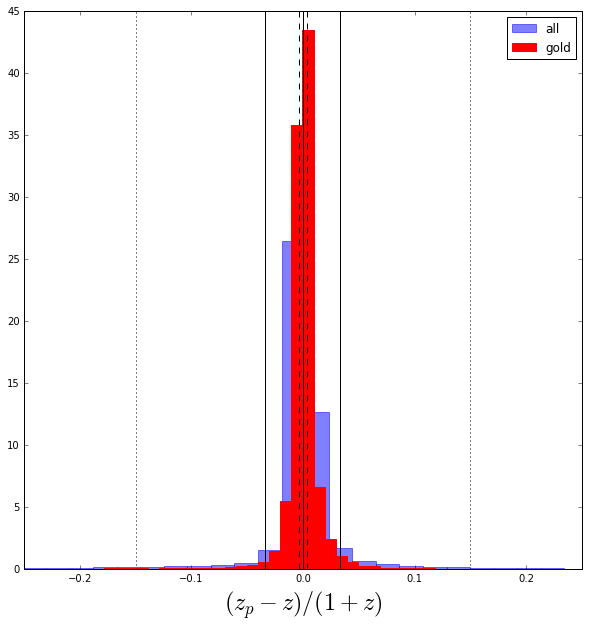

In [12]:
# Create figure with axes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# Plot histogram of e_z without doing any selection
pz.histogram_ez( # these are specific args to histogram_ez:
                 photoz_df["ez"], ax, plot_stats=False, 
                 # these are the (optional) matplotlib.pyplot.hist args:
                 bins=150, normed=True, facecolor='blue', edgecolor='blue', 
                 histtype='bar', alpha=0.5, orientation='vertical', label='all')

# Plot histogram of e_z WITH selection (gold sample only, see above)
pz.histogram_ez( # these are specific args to histogram_ez:
                 photoz_df["ez"], ax, iGold, plot_stats=True, 
                 # these are the (optional) matplotlib.pyplot.hist args:
                 bins=150, normed=True, facecolor='red', edgecolor='red', 
                 histtype='bar', orientation='vertical', label='gold')

# Finally add the labels etc that you want 
# (and also make any minor adjustments to the axes)
ax.set_xlabel('$(z_p-z)/(1+z)$', fontsize=24)
ax.set_xlim([-0.25, 0.25])
handles, labels = ax.get_legend_handles_labels()
ax.legend(prop={'size':12})

## Photo-z vs z scatter plot using `photoz_vs_z`

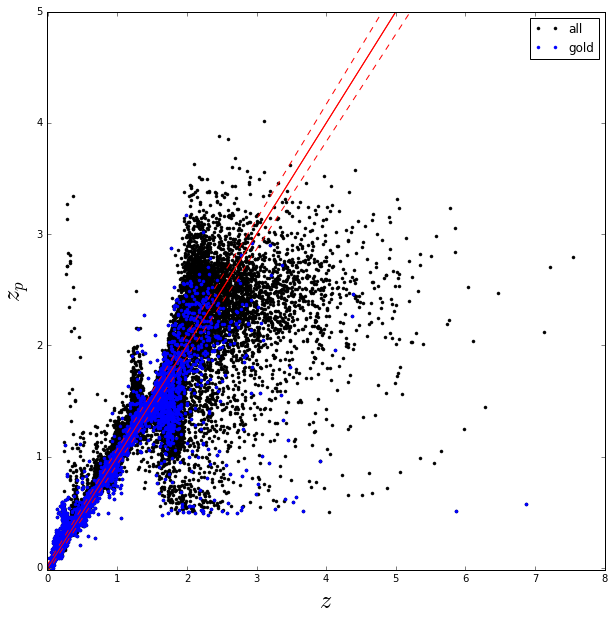

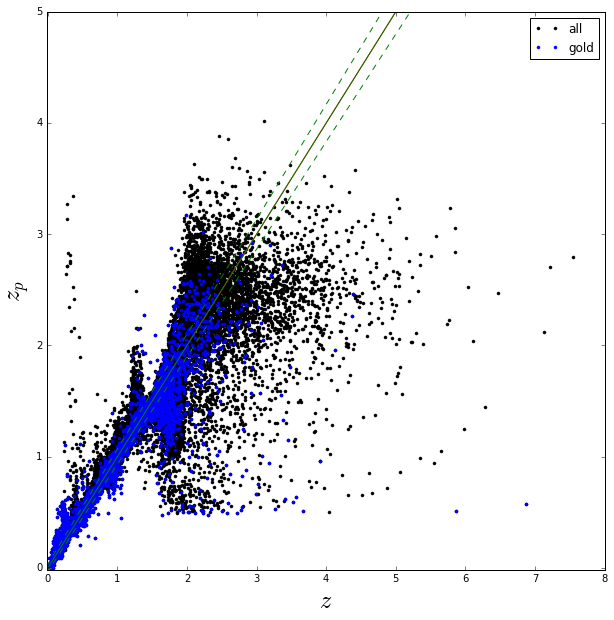

In [13]:
# Create figure with axes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# plot without doing any selection
pz.photoz_vs_z(joined["z_photo"], joined["z_true"], ax, # specific args
               marker='.', linestyle='none', color='black', label='all' # matplotlib args
               )

# plot WITH selection (gold sample only, see above) 
pz.photoz_vs_z(joined["z_photo"], joined["z_true"], ax, iGold, plot_sigs=True, # specific args
               marker='.', linestyle='none', color='blue', label='gold') # matplotlib args

# Finally add the labels etc that you want 
ax.set_xlabel('$z$', fontsize=24)
ax.set_ylabel('$z_p$', fontsize=24)
handles, labels = ax.get_legend_handles_labels()
ax.legend(prop={'size':12})


### Change the color of the guide lines (nearly identical to the above)

# Create figure with axes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# plot without doing any selection
pz.photoz_vs_z(joined["z_photo"], joined["z_true"], ax, # specific args
               marker='.', linestyle='none', color='black', label='all' # matplotlib args
               )

# plot WITH selection (gold sample only, see above) 
pz.photoz_vs_z( 
        # specific args:
        joined["z_photo"], joined["z_true"], ax, iGold, plot_sigs=True, guide_color='green',
        # matplotlib args:
        marker='.', linestyle='none', color='blue', label='gold') 

# Finally add the labels etc that you want 
ax.set_xlabel('$z$', fontsize=24)
ax.set_ylabel('$z_p$', fontsize=24)
handles, labels = ax.get_legend_handles_labels()
ax.legend(prop={'size':12})

## Plot statistics as a function of z using `one_stat_vs_redshift`

The choice of statisics (`stat` argument) that can be plotted are:

* SIGMA: IQR of $e_z$ divided by 1.34896
* BIAS: median of $e_z$
* OUTLIER: fraction with $\mid e_z\mid$>0.06 or fraction with $\mid e_z\mid>3\sigma$, whichever of 0.06 and $3\sigma$ is smaller
* CATASTROPHIC: catastrophic outlier, fraction with $\mid e_z\mid$>0.15

The redshift bins are supplied in a list of `[zmin, zmax, dz]`

LSST requirements can also be added separately to any plot using `add_LSST_req`


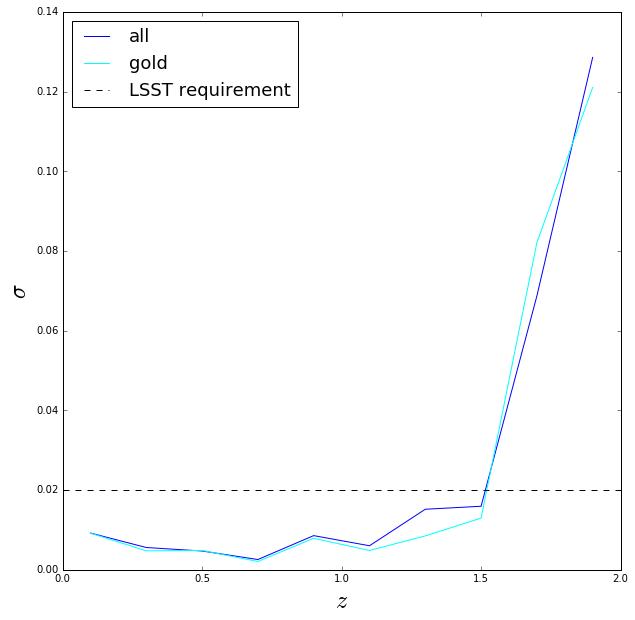

In [14]:
# Create figure with axes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# plot without doing any selection
pz.one_stat_vs_redshift( # specific arguments:
                         joined, "z_photo", "z_true", ax, stat='SIGMA', zbins=[0,2,0.2],
                         # matplotlib arguments:
                         color='blue')

# plot WITH selection (gold sample only, see above) 
pz.one_stat_vs_redshift( # specific arguments:
                         joined, "z_photo", "z_true", ax, selection=iGold, stat='SIGMA', 
                         zbins=[0,2,0.2],
                         # matplotlib arguments:
                         color='cyan')

# add in LSST requirements
pz.add_LSST_req(ax, req_type='SIGMA', 
                color='black', linestyle='dashed')

# change the legend label from its default
labels = ['all', 'gold', 'LSST requirement']
ax.legend(labels, prop={'size':18}, loc='upper left')

ax.set_ylabel('$\sigma$', fontsize=24)
ax.set_xlabel('$z$', fontsize=24)



## Plot all statistics as a function of z using `all_stats_vs_redshift`


(-0.10000000000000001, 0.4)

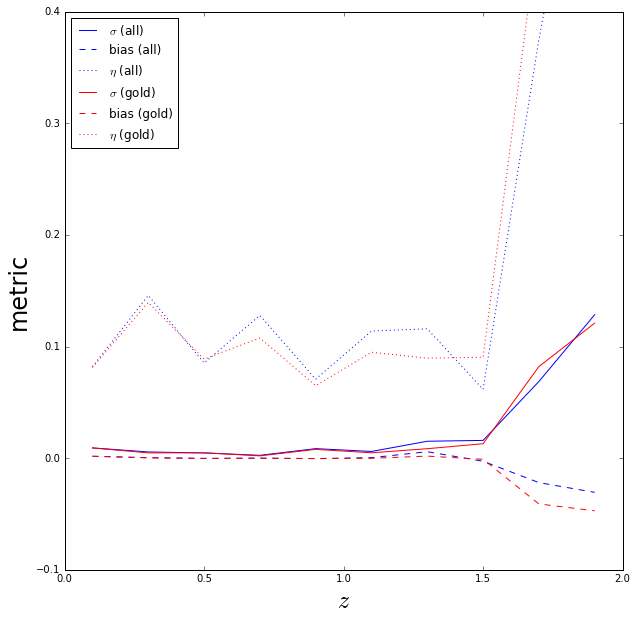

In [15]:
# Create figure with axes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# plot without doing any selection
pz.all_stats_vs_redshift(joined, "z_photo", "z_true", ax, color='blue')

# plot WITH selection (gold sample only, see above) 
pz.all_stats_vs_redshift(joined, "z_photo", "z_true", ax, iGold, color='red')


ax.set_xlabel('$z$', fontsize=24)
ax.set_ylabel('metric', fontsize=24)

# amend the legend slightly
handles, labels = ax.get_legend_handles_labels()
label_add = ['all', 'all', 'all', 'gold', 'gold', 'gold']
for i, la in enumerate(label_add):
    labels[i] += " (" + la + ")"
ax.legend(labels, prop={'size':12}, loc='upper left')

# reduce y-axis length a bit to zoom in
ylims = ax.get_ylim()
ax.set_ylim([ylims[0], 0.4])


## Distribution of photo-z as a function of z with `distribution_vs_redshift`

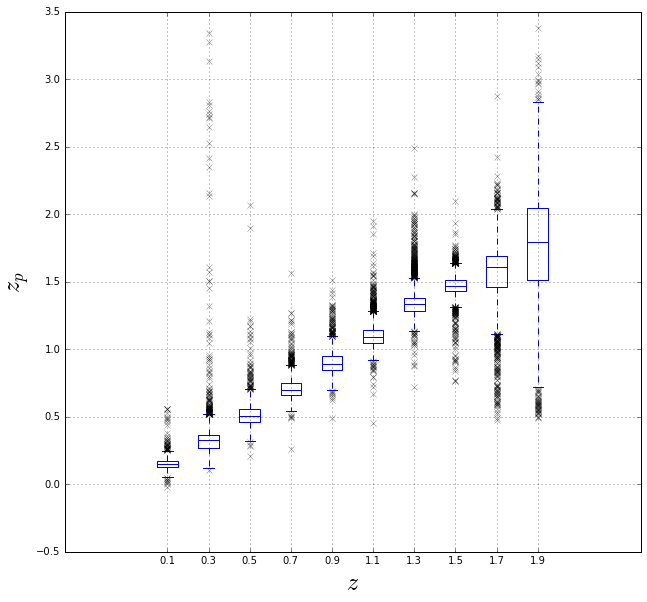

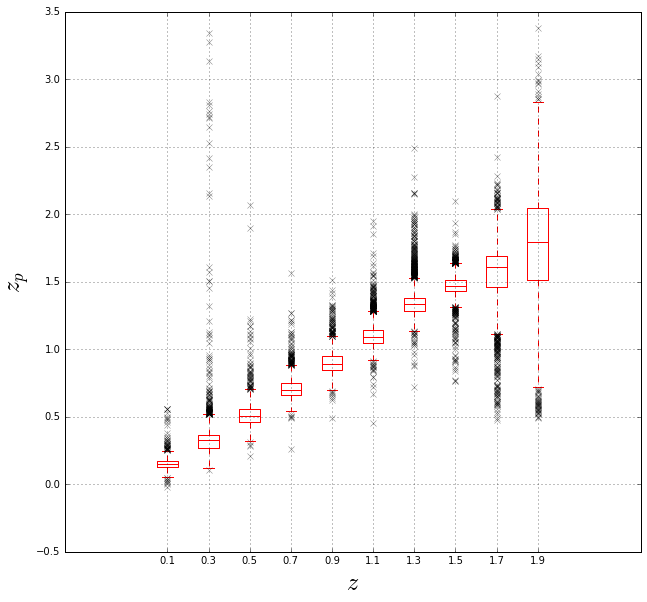

In [16]:
# no selection
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
pz.distribution_vs_redshift(joined, "z_photo", "z_true", ax, zbins=[0,2,0.2])
ax.set_xlabel('$z$', fontsize=24)
ax.set_ylabel('$z_p$', fontsize=24)

# with i<25.3 selection
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
pz.distribution_vs_redshift(joined, "z_photo", "z_true", ax, selection=iGold, 
                            zbins=[0,2,0.2], color='red')
ax.set_xlabel('$z$', fontsize=24)
ax.set_ylabel('$z_p$', fontsize=24)

# Write out the data

Finally, write out the values of the statistics:

* SIGMA: IQR of $e_z$ divided by 1.34896
* BIAS: median of $e_z$
* OUTLIER: fraction with $\mid e_z\mid$>0.06 or fraction with $\mid e_z\mid>3\sigma$, whichever of 0.06 and $3\sigma$ is smaller
* CATASTROPHIC: catastrophic outlier, fraction with $\mid e_z\mid$>0.15

to a file


In [17]:
outfile = 'performance.txt'
pz.output_stats_vs_redshift(outfile, joined, "z_photo", "z_true", 
                            selection=None, zbins=[0,2,0.2])